# Build  spectra for AuxTel with new spectractor (September 2021): Part 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16th 2021
- up date : September 21th  2021
- update : September 24th 2021 : quickLookExp and run locally
- version v3


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.7.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [6]:
from distutils.dir_util import copy_tree

# Path

In [7]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [8]:
HOSTCC=False

In [9]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Function

In [10]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [11]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [12]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v3.0.csv'

In [13]:
df=pd.read_csv(filename_logbook,index_col=0)

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file

In [16]:
idx=17

In [17]:
myhome=os.getenv("HOME")

In [18]:
dir_images=path_images

In [19]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits'

In [20]:
file_target(filename_image)

'HD160617'

## Configuration file 

Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [21]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000251_quickLookExp'

In [22]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [23]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [24]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp'

### manage output dir

In [25]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                os.remove(os.path.join(path,f))

In [26]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
 
    
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)
    
if not os.path.isdir(finalpath_output_spectractor):
    os.mkdir(finalpath_output_spectractor)
    os.mkdir(os.path.join(finalpath_output_spectractor,"spectrum"))
    os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
else:
    #cleandir(finalpath_output_spectractor)
    cleandir(os.path.join(finalpath_output_spectractor,"spectrum"))
    cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the running mode

In [27]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [28]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

In [29]:
from shutil import copyfile

In [30]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits'

In [31]:
from astropy.io import fits

In [32]:
hdu = fits.open(filename_image)

In [33]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [34]:
header=hdu[0].header
image=hdu[0].data

In [35]:
hdu.close()

## Rotate image

In [36]:
rot_image=np.flip(np.flip(image, 1), 0)

### Remove WCS

In [37]:
del header['WCSAXES']
del header['CTYPE1']
del header['CTYPE2']
del header['CUNIT1']
del header['CUNIT2']
del header['CRVAL1']
del header['CRVAL2']
del header['CRPIX1']
del header['CRPIX2']

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [38]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [39]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [40]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     114   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [41]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new file

In [42]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

2021-09-24 23:57:53  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.3537105566409 but average of self.read_out_noise is 8.5.


## Show relevant parameters

In [43]:
parameters.OBS_NAME

'AUXTEL'

In [44]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [45]:
parameters.DISTANCE2CCD

182.0

In [46]:
parameters.LAMBDA_MIN 

300

In [47]:
parameters.LAMBDA_MAX 

1100

In [48]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [49]:
image.filter_label

''

In [50]:
image.header["FILTER"]

'empty_1'

In [51]:
#image.header

# Plot image and find the target position

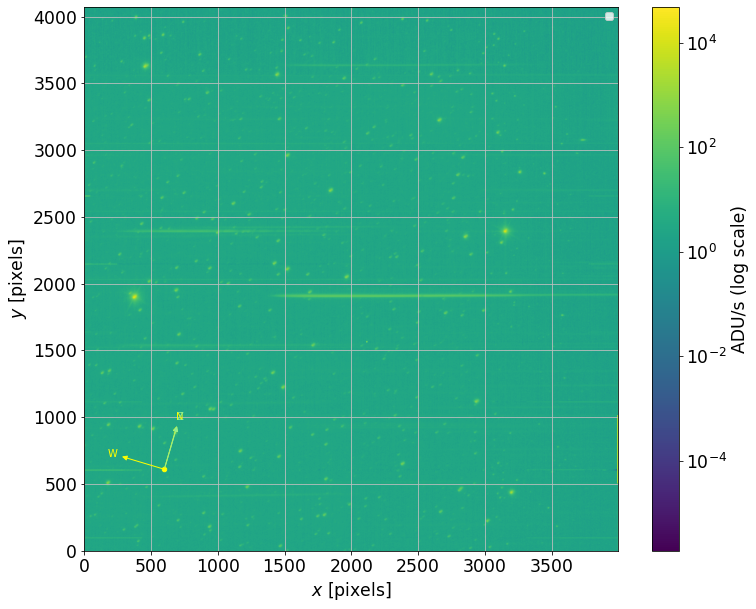

In [52]:
image.plot_image(figsize=(12, 10),scale="log")

In [53]:
filename_image

'holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits'

In [54]:
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits

In [55]:
filename_image

'holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits'

2021-09-24 23:57:59  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                 c0_1        
    ------------------ --------------------- --------------------
    1.6780174846564335 -0.008096898720727575 0.031066557453954056
2021-09-24 23:57:59  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


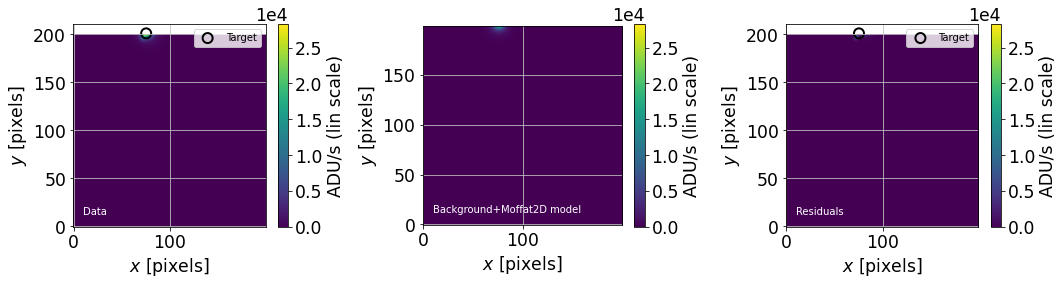

2021-09-24 23:58:00  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


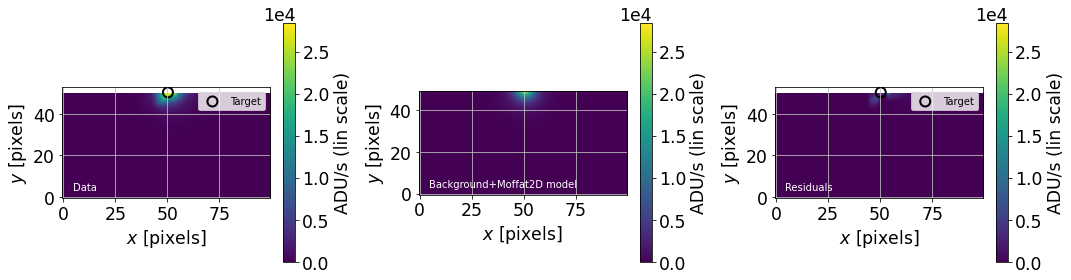

In [56]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [57]:
print(x1,y1)

375.3166007005345 1900.2903976519024


In [58]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [59]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [60]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [61]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [62]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [63]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [64]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [65]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [66]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [67]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [68]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [69]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [70]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.05, 0.2, 'normal  : p_test   = 0.000e+00\n             : p_test_x = 8.477e-33\n             : p_test_y = 6.059e-39')

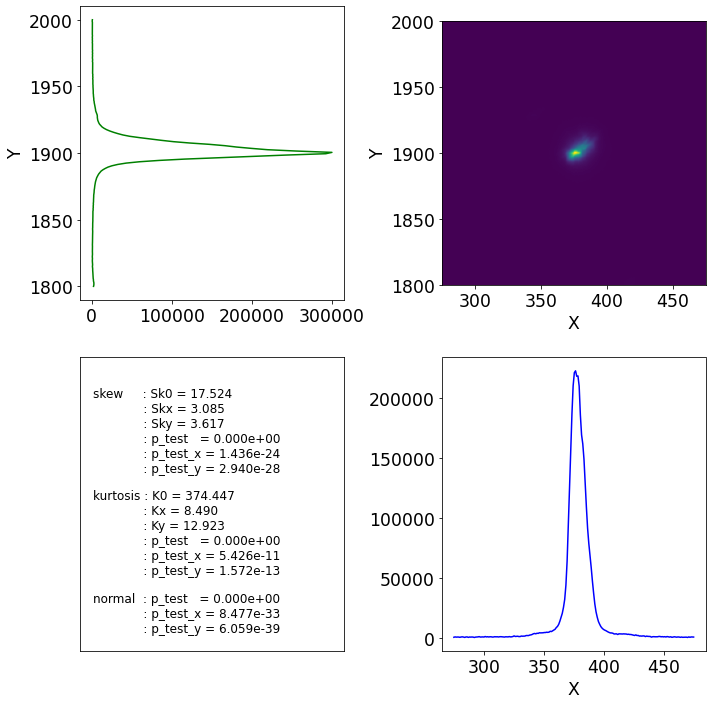

In [71]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-09-24 23:58:02  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-09-24 23:58:02  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits...
2021-09-24 23:58:02  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-09-24 23:58:02  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-09-24 23:58:02  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-09-24 23:58:02  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-09-24 23:58:06  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.3537105566409 but average of self.read_out_noise is 8.5.
2021-09-24 23:58:06  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350               

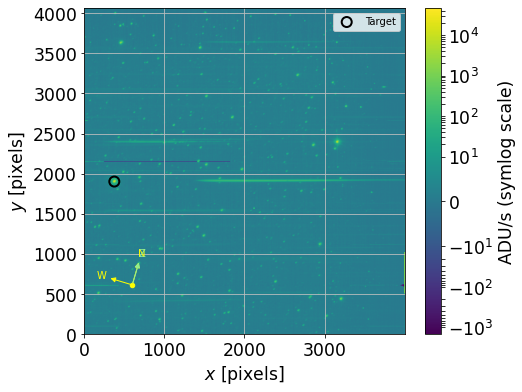

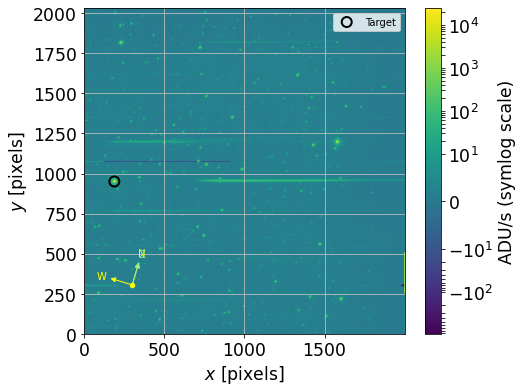

2021-09-24 23:58:13  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[187.65830035 950.14519883]...
2021-09-24 23:58:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                  c0_1        
    ------------------ -------------------- ---------------------
    4.1552124790496325 0.009168578123975679 0.0027478430936392515
2021-09-24 23:58:13  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


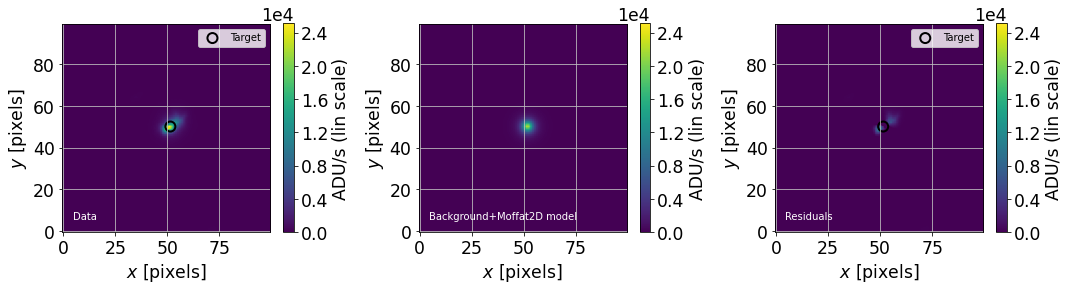

2021-09-24 23:58:14  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=0.0002.


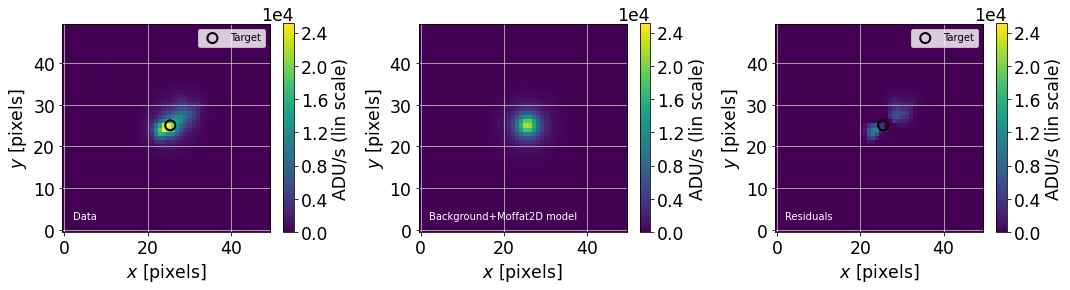

2021-09-24 23:58:15  Image      find_target          INFO   
	X,Y target position in pixels: 188.462,950.072
2021-09-24 23:58:15  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


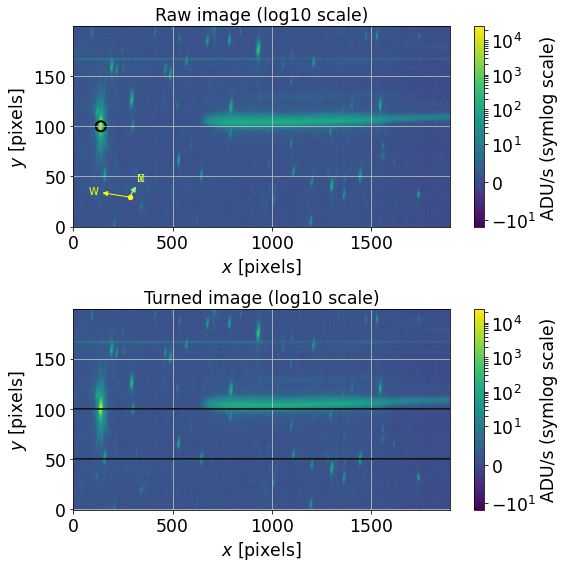

2021-09-24 23:58:18  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-09-24 23:58:18  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                c0_1       
    ------------------ ------------------ -------------------
    14.246510383778903 0.0928799522307848 0.12009659539347445
2021-09-24 23:58:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=0.0002.


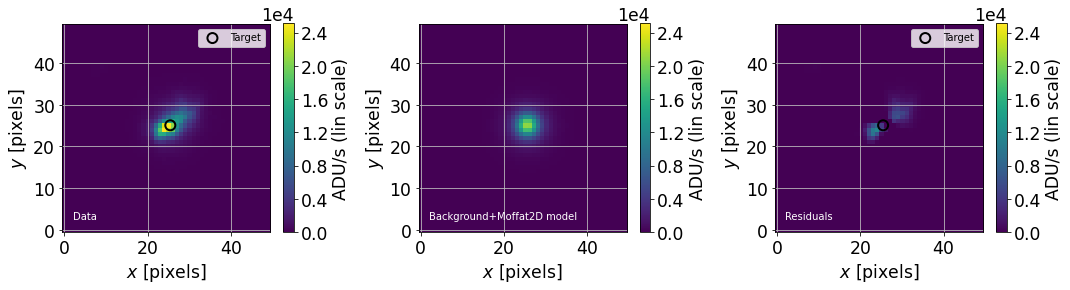

2021-09-24 23:58:19  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0008680555555555555.


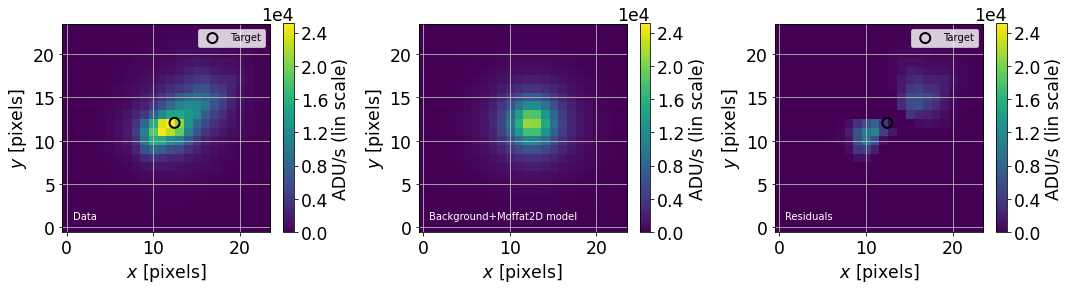

2021-09-24 23:58:20  Image      find_target          INFO   
	X,Y target position in pixels: 188.453,950.061
2021-09-24 23:58:20  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-09-24 23:58:20  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-09-24 23:58:20  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [615:1773,860:1040] (size (1158, 180))


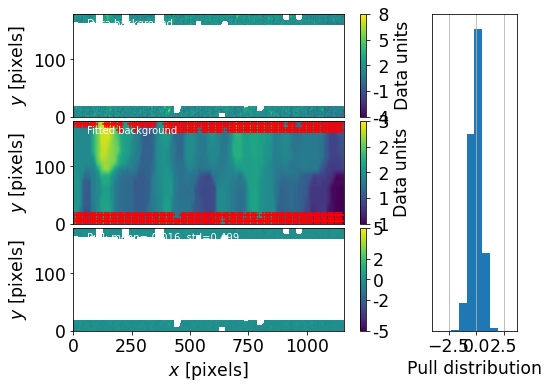

2021-09-24 23:58:23  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: invalid value encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm


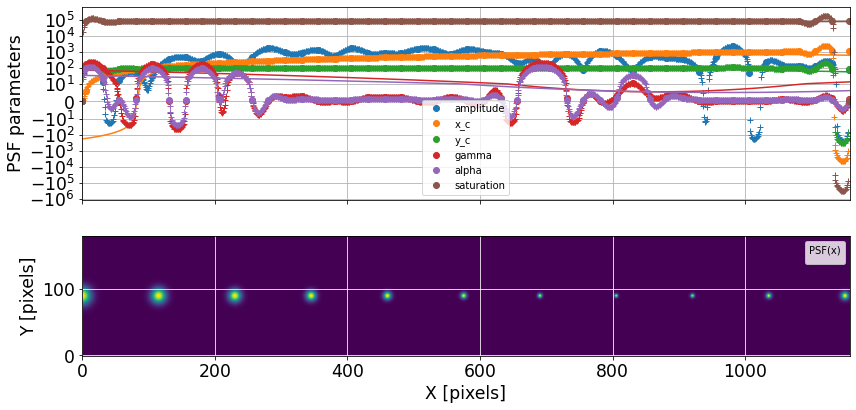

2021-09-24 23:58:27  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.6323e+05 initial chisq_red=5.6828
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.14457418 -0.25065725  0.51496473 -2.89860899  3.90002065 -6.5261237
 -3.98017402  3.55034468 -6.86497053]
	New parameters: [ 7.64905933  6.19971344  5.60767433  0.90929453 -0.18312082 -0.71288908
 -1.17523832  1.36739848 -3.57976537]
	Final cost=2.5379e+05 final chisq_red=5.479 computed in 0.60s
2021-09-24 23:58:27  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_0 has a null Jacobian; parameter is fixed at its last known current value (-1.1752383203142194).
2021-09-24 23:58:27  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_1 has a null Jacobian; parameter is fixed at its last known current value (1.3673984782929107).
2021-09-24 23:58:27  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_2 has a null Jacobian; parameter is fi

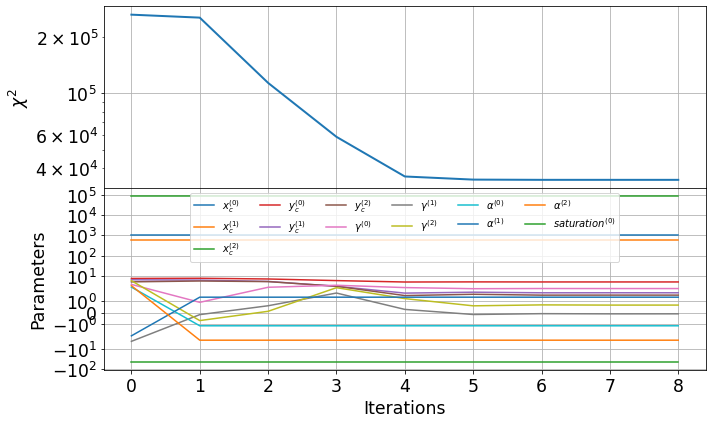

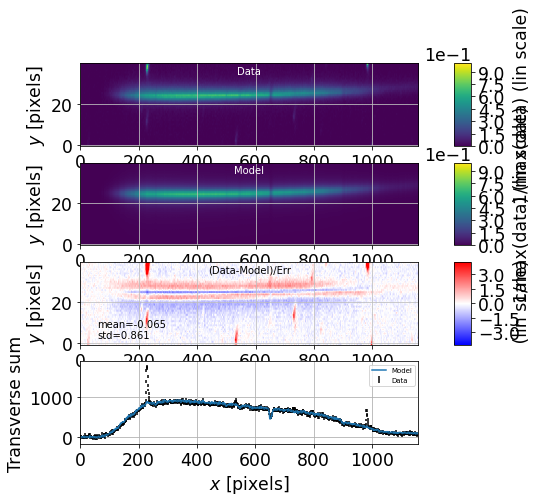

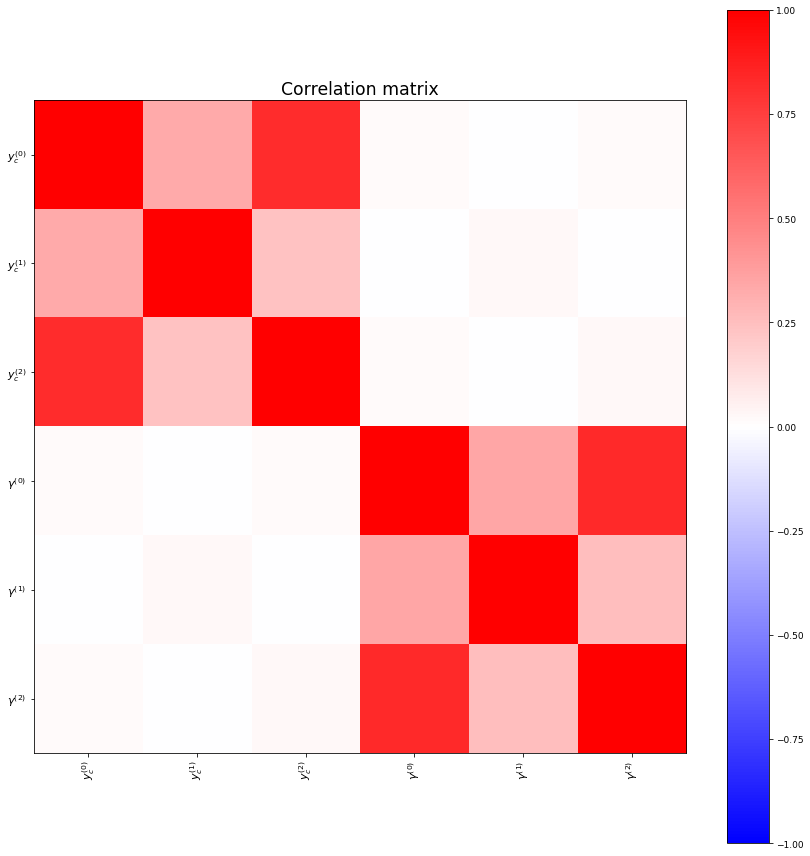

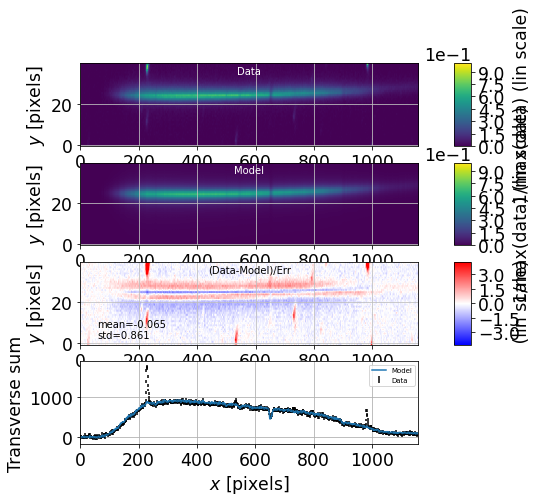

2021-09-24 23:58:37  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude       x_c          y_c        ...         Dy         Dy_disp_axis
------------------- ------ ----------------- ... ------------------ ------------
-25.810324749051127    0.0 94.88610032531624 ...  4.825301451111997          0.0
 -8.006363008906092    1.0 94.88110538681637 ... 4.8203065126121345          0.0
-17.465033038917547    2.0 94.87612435015694 ...  4.815325475952704          0.0
 -2.009761157634782    3.0 94.87115721533794 ...  4.810358341133707          0.0
  3.674132685418761    4.0 94.86620398235937 ...  4.805405108155128          0.0
  9.716940074799854    5.0  94.8612646512212 ...  4.800465777016967          0.0
  4.669237614355399    6.0 94.85633922192349 ...  4.795540347719253          0.0
  4.774516211346887    7.0 94.85142769446618 ...  4.790628820261944          0.0
-13.440718659422144    8.0  94.8465300688493 ... 4.785731194

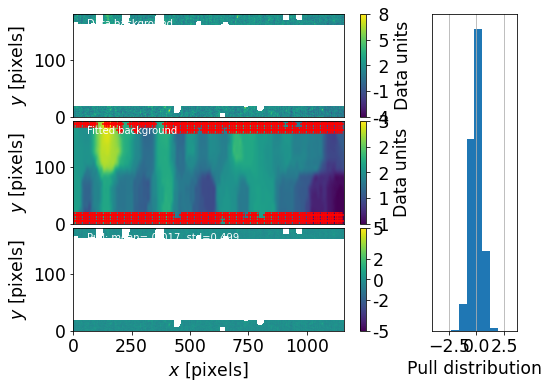

2021-09-24 23:58:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=1.683 ADU/s, RMS=1.911 ADU/s.
2021-09-24 23:58:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [614:1772,860:1041] (size (1158, 181))
	New target position in spectrogram frame: [-425.53783053426866, 90.07244322738961]


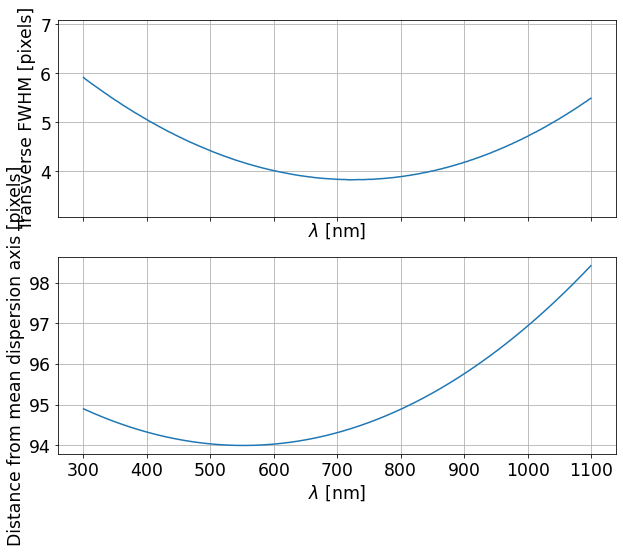

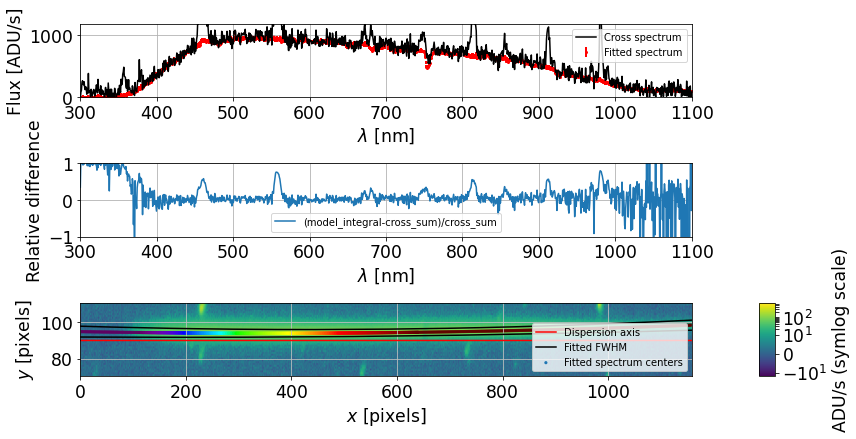

2021-09-24 23:58:41  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


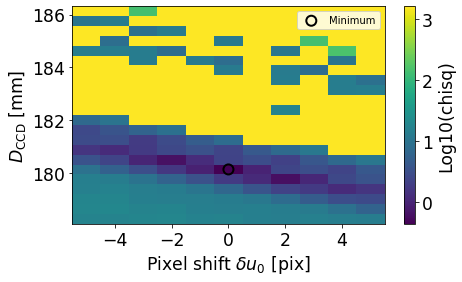

2021-09-24 23:58:55  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.013pix
	D = 180.123 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.5 sigma shift)
2021-09-24 23:58:57  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-09-24 23:59:08  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.2132e+05 initial chisq_red=12.36
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [2.52428509 0.12726878]
	New parameters: [2.52428509 0.12726878]
	Final cost=1.3728e+05 final chisq_red=3.2548 computed in 9.28s
2021-09-24 23:59:17  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.3728e+05 initial chisq_red=3.2548
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.88971066  0.03555746]
	New parameters: [1.63457443 0.16282624]
	Final cost=1.3424e+05 final chisq_red=3.1826 computed in 9.21s
2021-09-24 23:59:26  sp

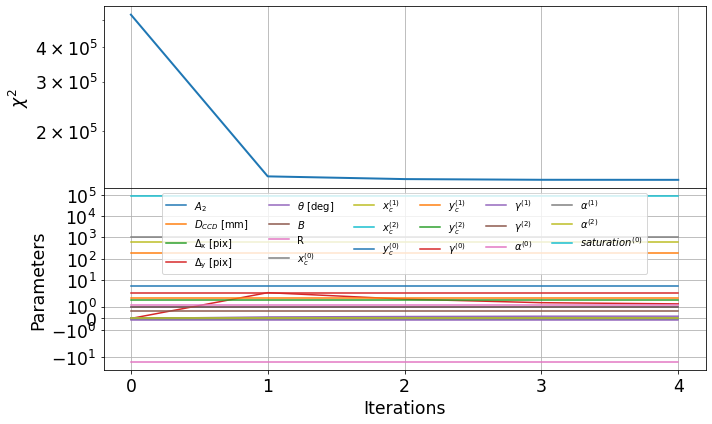

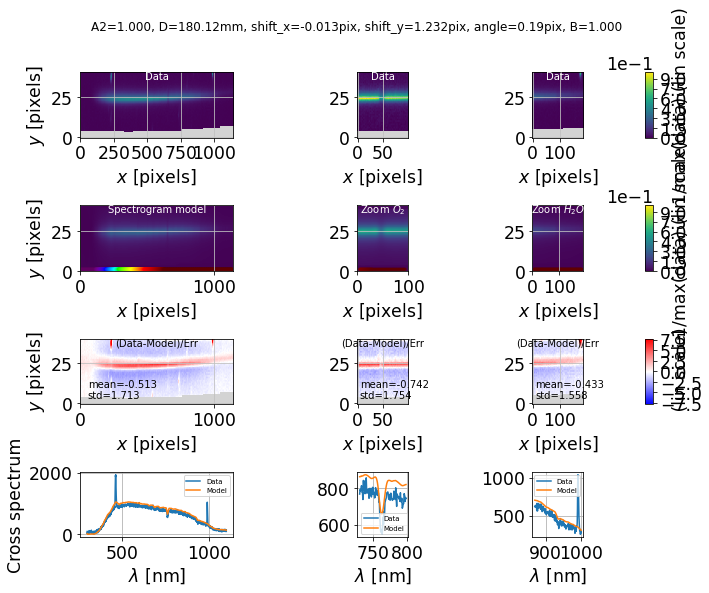

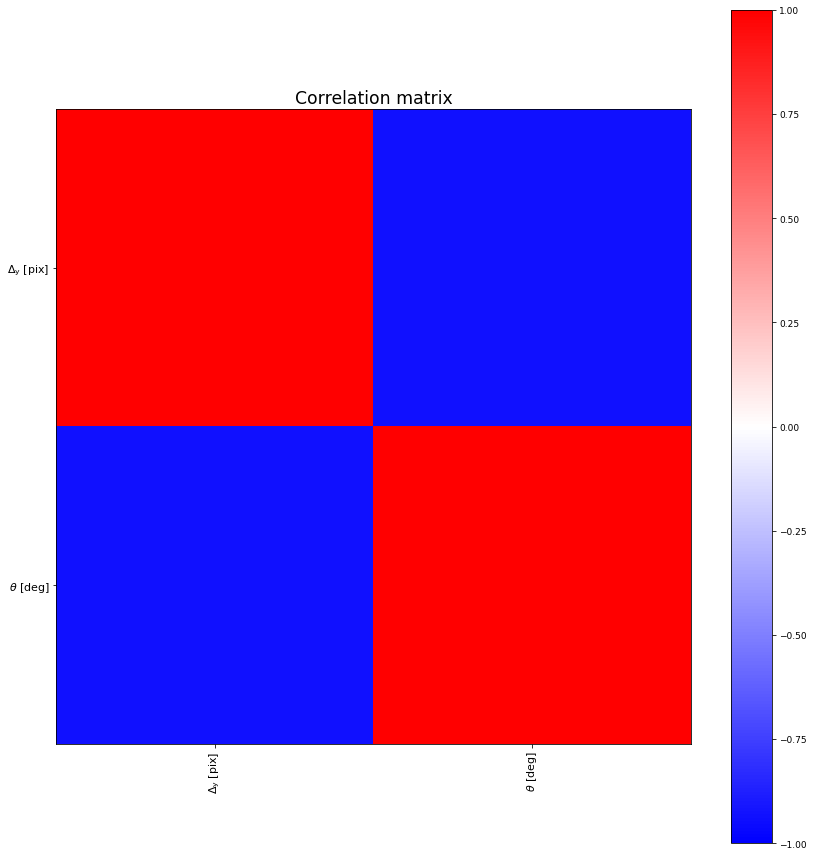

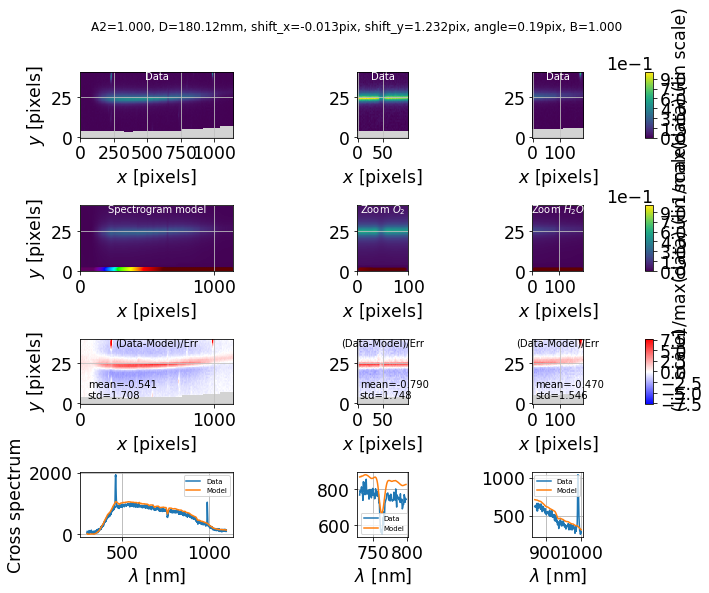

2021-09-24 23:59:43  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80122545e+02 -1.34308573e-02  1.23247464e+00
  1.91364672e-01  1.00000000e+00 -1.64033577e+01  1.00504680e+03
  5.78500000e+02 -7.96239107e-13  5.03332255e+00  1.75882817e+00
  1.55080707e+00  2.37638053e+00 -1.12084627e-01  6.65384746e-01
  1.10000000e+00 -1.10614145e-16 -7.36268611e-16  8.48255489e+04]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-09-24 23:59:55  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: alpha_1 has a null Jacobian; parameter is fixed at its last known current value (-1.1061414503558235e-16).
2021-09-24 23:59:55  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: alpha_2 has a null Jacobian; parameter is fixed at its last known current value (-7

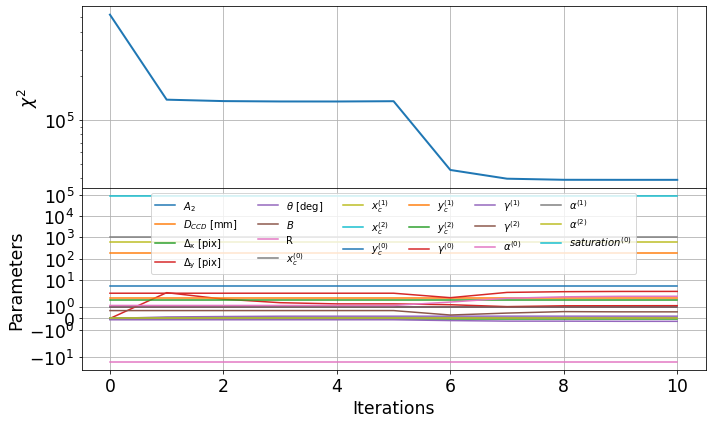

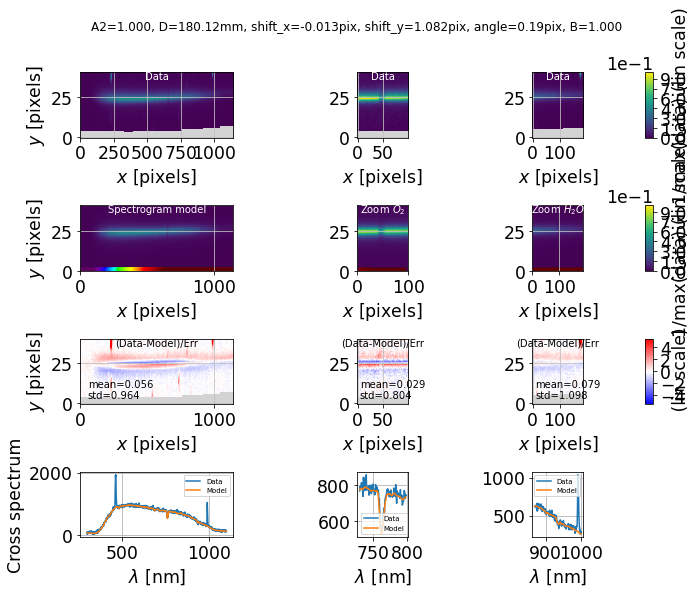

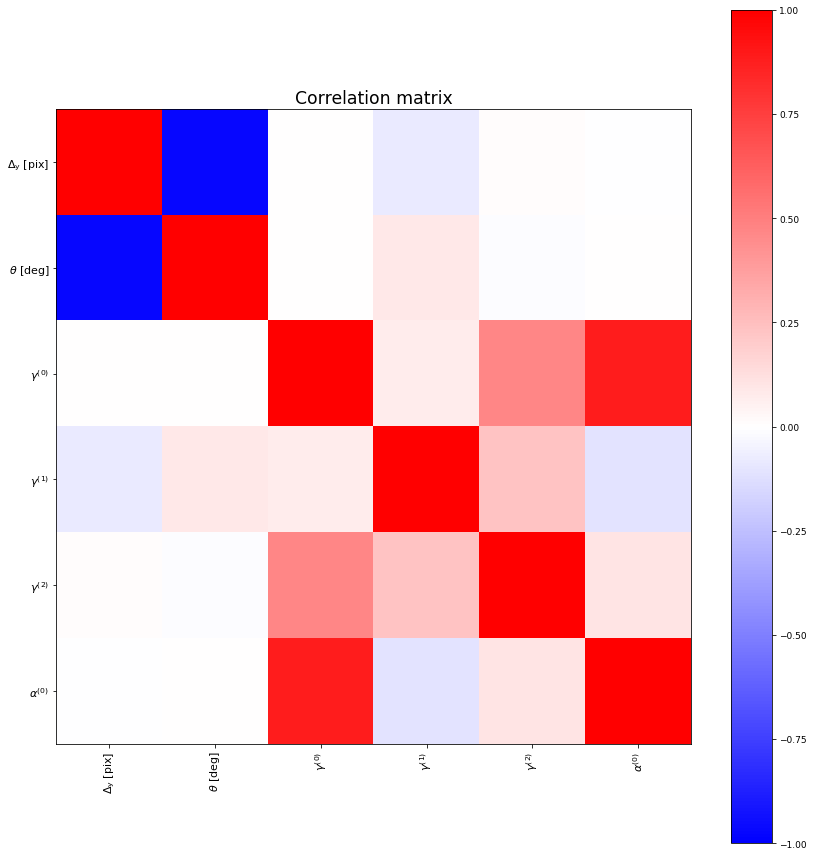

2021-09-25 00:00:59  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-09-25 00:01:11  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[4.1876875],
       [4.18775  ]]), array([2.42628852e-10, 2.42628852e-10]))
           fun: 2.426288520283705e-10
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 29
        status: 0
       success: True
             x: array([4.1876875])
2021-09-25 00:01:11  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 11.391886949539185s


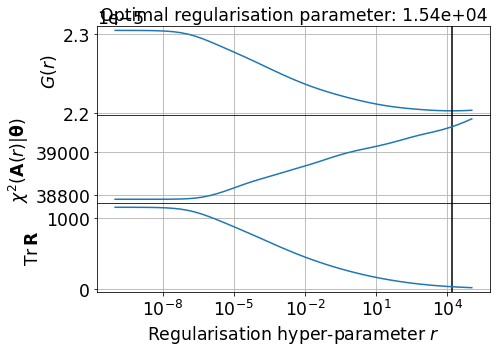

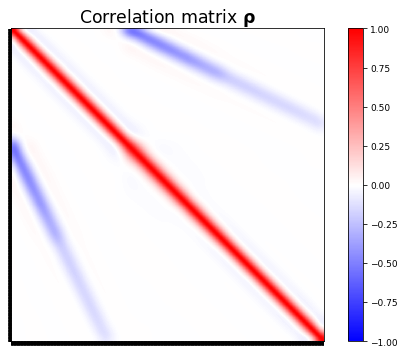

2021-09-25 00:01:34  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 15405.915093217069
	Tr(R) = 37.22216450203712
	N_params = 1158
	N_data = 42178 (without mask and outliers)
2021-09-25 00:01:35  FullForwardModelFitWorkspace run_ffm_minimisation WARNING 
	Trace of final covariance matrix (21195.083741003862) is below the trace of the prior covariance matrix (660149.8939404159). This is probably due to a very high regularisation parameter in case of a bad fit. Therefore the final covariance matrix is mulitiplied by the ratio of the traces and the amplitude parameters are very close the amplitude priors.
2021-09-25 00:01:50  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=39120 initial chisq_red=0.92802
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.58366315e-04  4.09037402e-05 -4.33509990e-04 -5.72743137e-04
 -3.50306231e-03 -1.95949004e-03]
	New parameters: [ 1.08155685  0.19360134  2.89021029

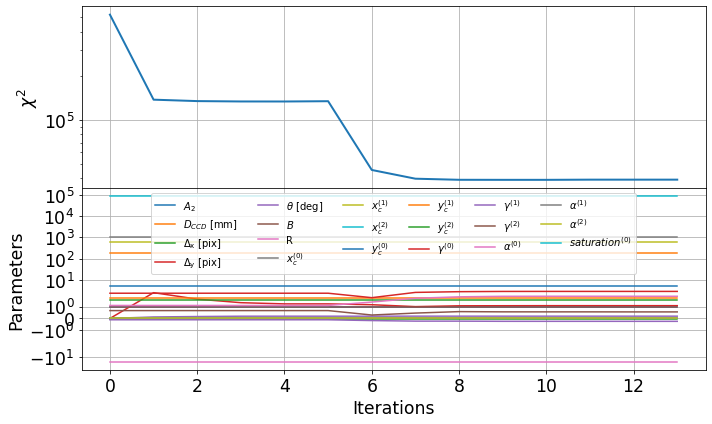

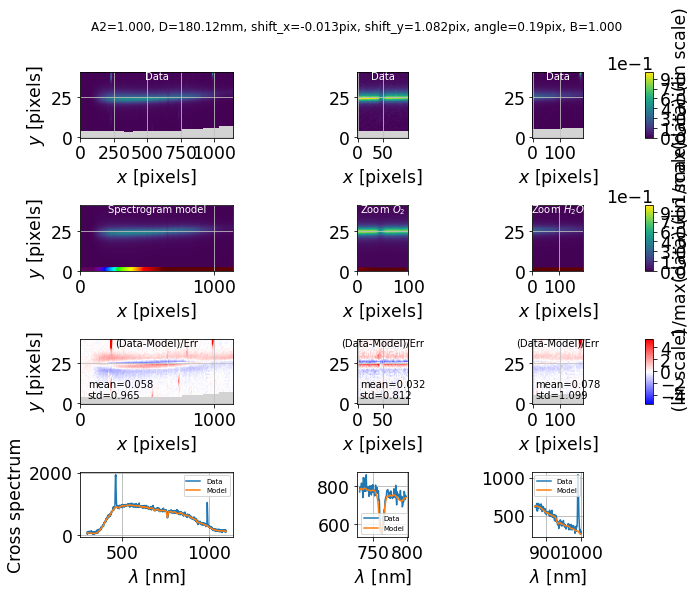

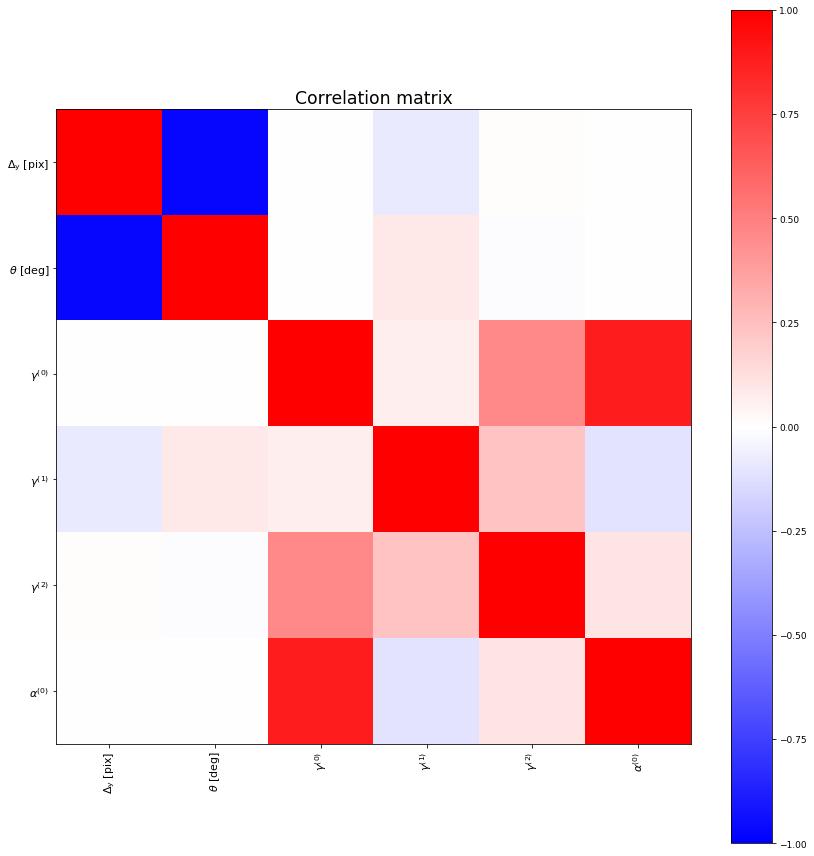

2021-09-25 00:02:09  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [46143, 46144, 47302, 47303, 47304]
2021-09-25 00:02:09  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-09-25 00:02:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=36722 initial chisq_red=0.87114
		 Line search: alpha_min=0.0882 iter=4 funcalls=8
	Parameter shifts: [-4.57588448e-04  2.64010242e-05  8.70723658e-05 -2.89889969e-05
 -1.24064377e-04  7.16530195e-05]
	New parameters: [ 1.08136885  0.19362607  2.8907378  -0.24397187  0.55409683  1.87724219]
	Final cost=36722 final chisq_red=0.87114 computed in 16.41s
2021-09-25 00:02:46  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=36722 initial chisq_red=0.87114
		 Line search: alpha_min=0.145 iter=6 funcalls=10
	Parameter shifts: [ 8.02174846e-04 -4.69044973e-

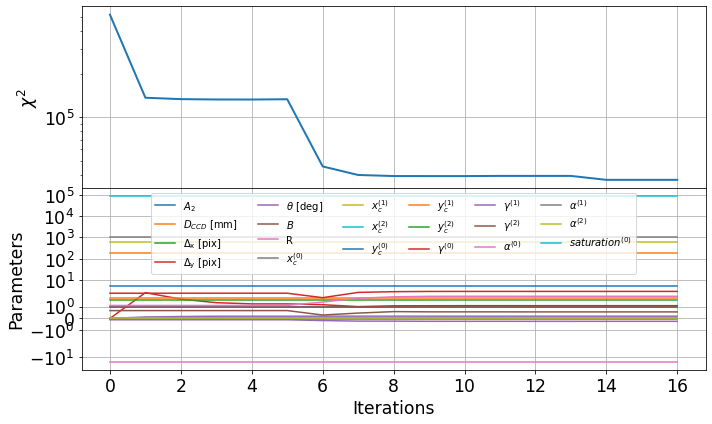

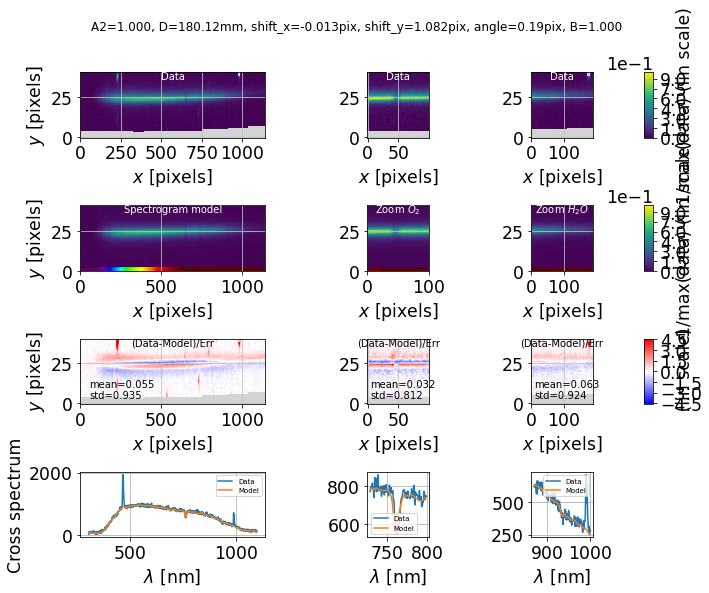

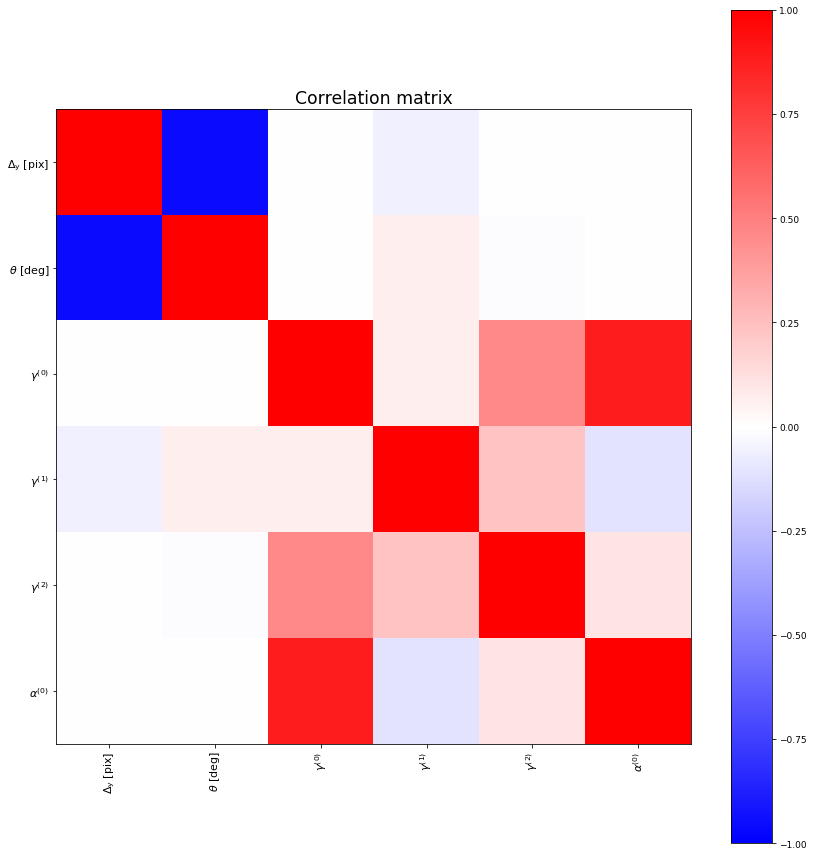

2021-09-25 00:02:51  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [46143, 46144, 47302, 47303, 47304]
2021-09-25 00:02:51  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-09-25 00:02:51  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-09-25 00:02:51  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 188.1958258152008s


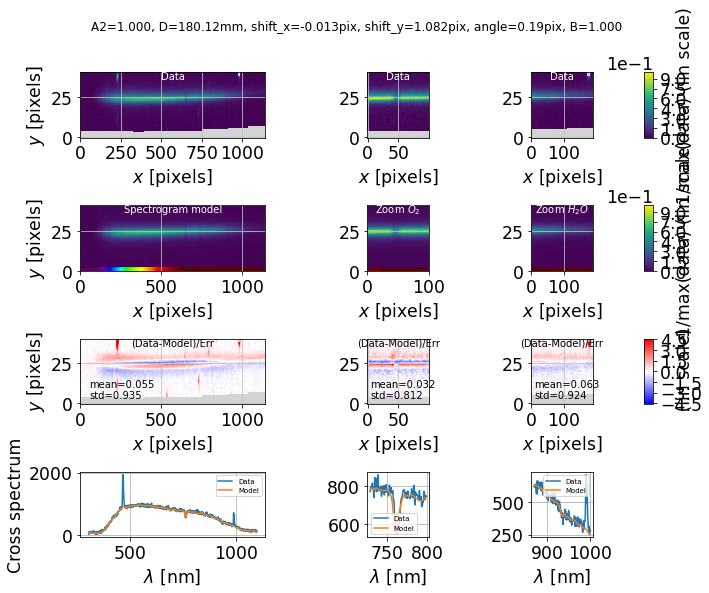

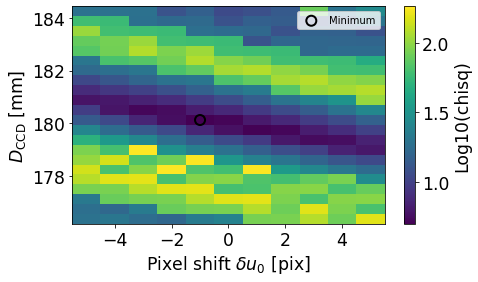

2021-09-25 00:03:10  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.089pix
	D = 180.013 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.6 sigma shift)
2021-09-25 00:03:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=36733 initial chisq_red=0.87141
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 4.76770293e-04  3.74935638e-05  2.66701378e-04 -1.79668124e-04
 -5.09703226e-04  2.75445096e-04]
	New parameters: [ 1.0826478   0.19361666  2.89114839 -0.24433806  0.55343993  1.87763001]
	Final cost=36733 final chisq_red=0.87141 computed in 12.05s
2021-09-25 00:03:38  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=36733 initial chisq_red=0.87141
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-9.37420437e-05  7.89969327e-06  1.28835016e-03 -3.10612201e-05
 -6.79834567e-04  6.72595923e-04]
	New parameters: [ 1.08255406  0.19362456  2.89243674 -0.24436912  0.5527601   1.8783

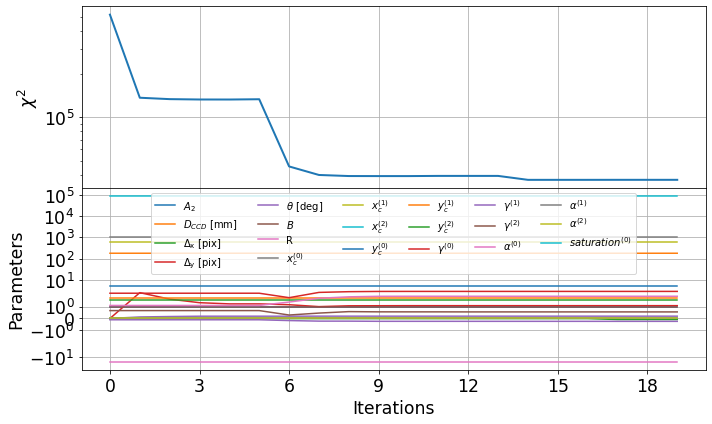

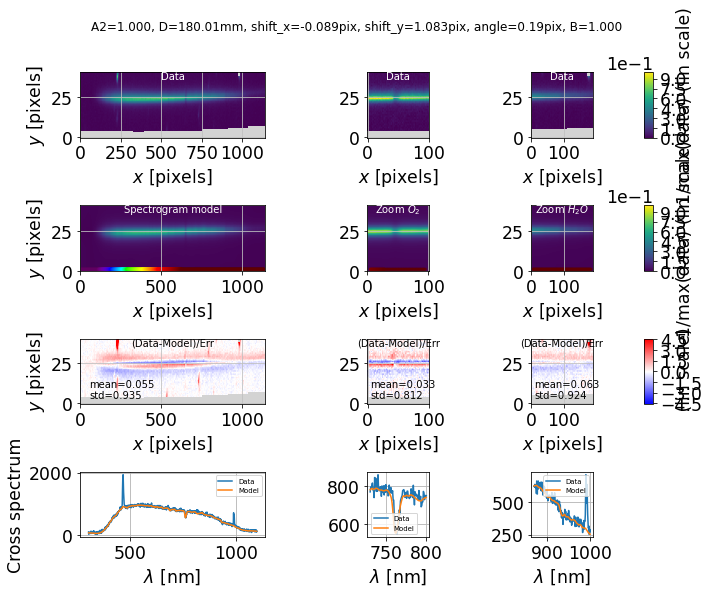

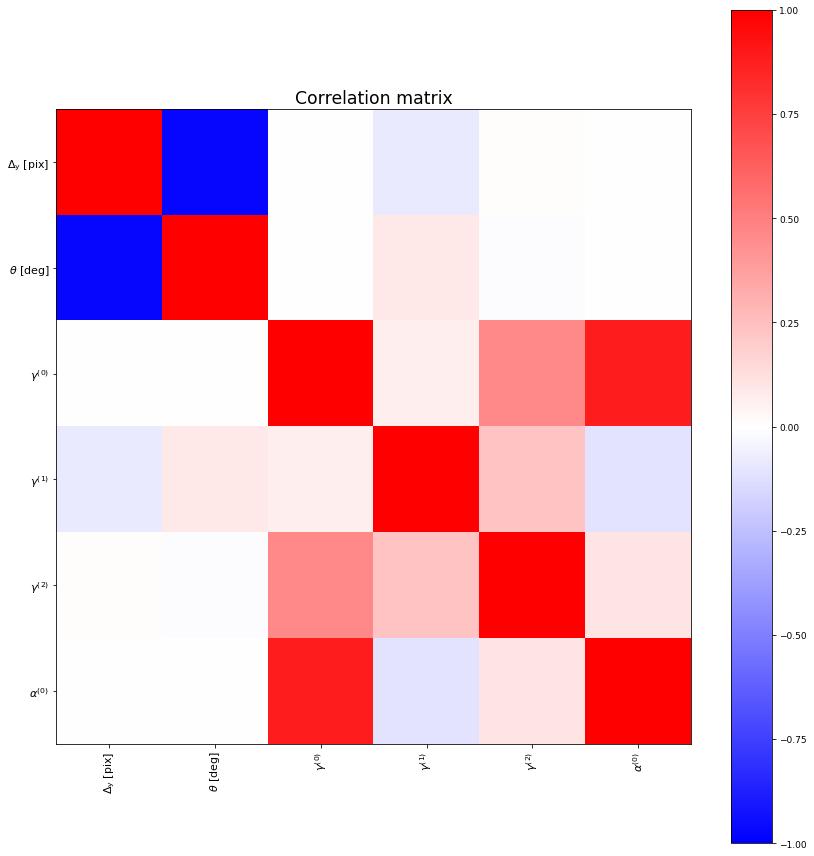

2021-09-25 00:03:43  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [46143, 46144, 47302, 47303, 47304]
2021-09-25 00:03:43  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-09-25 00:03:43  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-09-25 00:03:43  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 240.4206600189209s


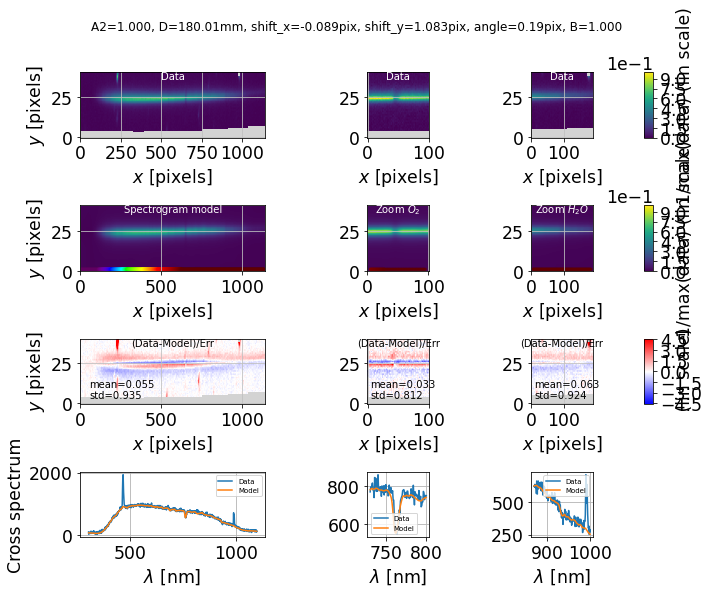

In [ ]:
#spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Remove temporary file

In [ ]:
os.remove(filename_image)

# Backup output

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"spectrum"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))